Critique from reviewer:

_For testing how well the model predicted a ground truth value, it should be possible to calculate the log probability density of the true value according to the model. This is usually a better metric than correlation coefficient._

In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

In [3]:
ant ='../../../models/Antimony/topologyB-noReg.ant' 
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.7241056990445864e-15

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [5]:
data01 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.1.csv')[fluxes+internal+external]
data02 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.2.csv')[fluxes+internal+external]
data03 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.3.csv')[fluxes+internal+external]
data04 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.4.csv')[fluxes+internal+external]
data05 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_0.5.csv')[fluxes+internal+external]

data15 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_1.5.csv')[fluxes+internal+external]
data3 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_3.csv')[fluxes+internal+external]
data5 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_5.csv')[fluxes+internal+external]
data7 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_7.csv')[fluxes+internal+external]
data100 = pd.read_csv('../../../data/generated_data/TopologyB-noReg/TopologyB-noReg_10.csv')[fluxes+internal+external]


In [6]:
BMCA_obj01 = antemll.antemll(ant, data01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


## Analysis


In [7]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyB-noReg_omitEnzymes_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [8]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']
trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

In [9]:
from scipy.stats import gaussian_kde

def get_logp(trace, true_values):  
    """
    Estimate marginal logp at each ground truth value using KDE.

    Parameters:
    - trace: ArviZ InferenceData object containing posterior samples
    - true_values: numpy array of shape (16, 11) representing ground truth

    Returns:
    - logps: numpy array of shape (16, 11) of log probabilities
    """

    samples = trace.posterior["Ex"].stack(sample=("chain", "draw")).values  # shape: (16, 11, 1000)
    samples = np.moveaxis(samples, -1, 0)  # shape: (1000, 16, 11)
    
    logps = np.zeros_like(true_values)

    for i in range(true_values.shape[0]):
        for j in range(true_values.shape[1]):
            var_samples = samples[:, i, j]
            kde = gaussian_kde(var_samples)
            logps[i, j] = np.log(kde(true_values[i, j]))

    return np.array(logps)


In [10]:
logp_array = get_logp(trace100[0], true_values=r.getScaledElasticityMatrix())  # where Ex_true is your (16, 11) ground truth

C:\Users\user\AppData\Local\Temp\ipykernel_3488\95413887.py:24: RuntimeWarning:

divide by zero encountered in log



In [11]:
pd.DataFrame(logp_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.227729,-5.161986,1.511634,2.202322,1.947573,1.656908,2.264066,2.526096,1.923743,2.111389,1.605360,2.037277,1.727454
1,2.113825,-133.601058,1.641645,2.141134,1.896239,1.620637,2.136219,-inf,1.887803,2.090988,1.616238,1.847601,1.690690
2,2.113850,1.882865,1.477141,2.072518,1.964685,1.665567,2.303609,-82.598458,1.913008,2.112493,1.557616,1.978142,1.743924
3,2.180782,-233.253051,1.600126,2.228790,1.929269,1.713786,2.215516,2.461913,1.861607,-376.459495,1.616615,1.970622,1.695730
4,-514.622283,2.049863,1.450177,2.157248,1.858853,1.663693,2.298174,2.523492,1.943428,-344.326433,1.542911,1.924054,1.734908
5,-inf,2.001690,1.579461,2.130875,2.006401,1.694989,-inf,2.451982,1.899002,2.092661,1.571272,1.980508,1.761847
6,2.341236,2.017815,1.575522,2.222295,2.008561,1.647630,-110.335168,2.414735,1.912712,1.988321,1.613890,2.014540,1.743980
7,-inf,1.971058,1.627861,-inf,1.884950,1.686252,2.211771,2.509642,1.948938,1.933231,1.655871,1.907674,1.797135
8,-443.603398,1.956438,1.513634,2.098031,1.854631,1.646570,2.211235,2.493607,2.000527,2.071285,1.640783,-557.792352,1.739798
9,1.995073,2.018074,1.566399,2.002591,-inf,1.652038,2.075032,2.472826,1.942363,1.981069,1.610492,-inf,1.738042


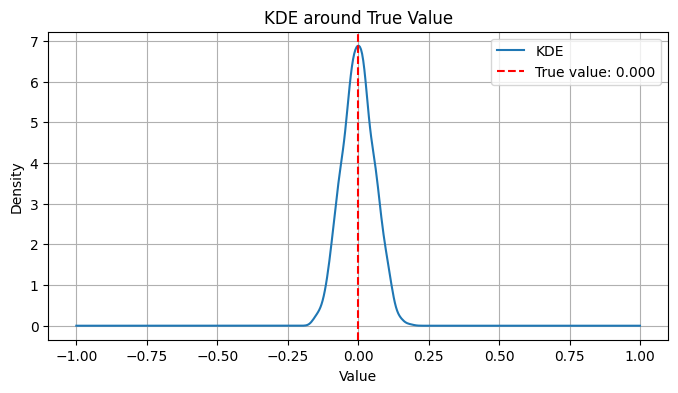

Bandwidth: 0.2512
Max density: 6.8835


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def inspect_kde(samples, true_value):
    # Fit KDE
    kde = gaussian_kde(samples)

    # Evaluate density around the true value
    x_grid = np.linspace(true_value - 1, true_value + 1, 500)
    density = kde(x_grid)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x_grid, density, label="KDE")
    plt.axvline(true_value, color='red', linestyle='--', label=f"True value: {true_value:.3f}")
    plt.title("KDE around True Value")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Bandwidth: {kde.factor:.4f}")
    print(f"Max density: {np.max(density):.4f}")

samples = trace100[0].posterior['Ex'].stack(sample=("chain", "draw")).values[3, 4]
true_value = r.getScaledElasticityMatrix()[3, 4]
inspect_kde(samples, true_value)


## Summary statistics and plots

In [13]:
print("min logp:", logp_array.min())
print("max logp:", logp_array.max())
print('median logp', np.median(logp_array))

min logp: -inf
max logp: 2.5337903790136265
median logp 1.8754993148756047


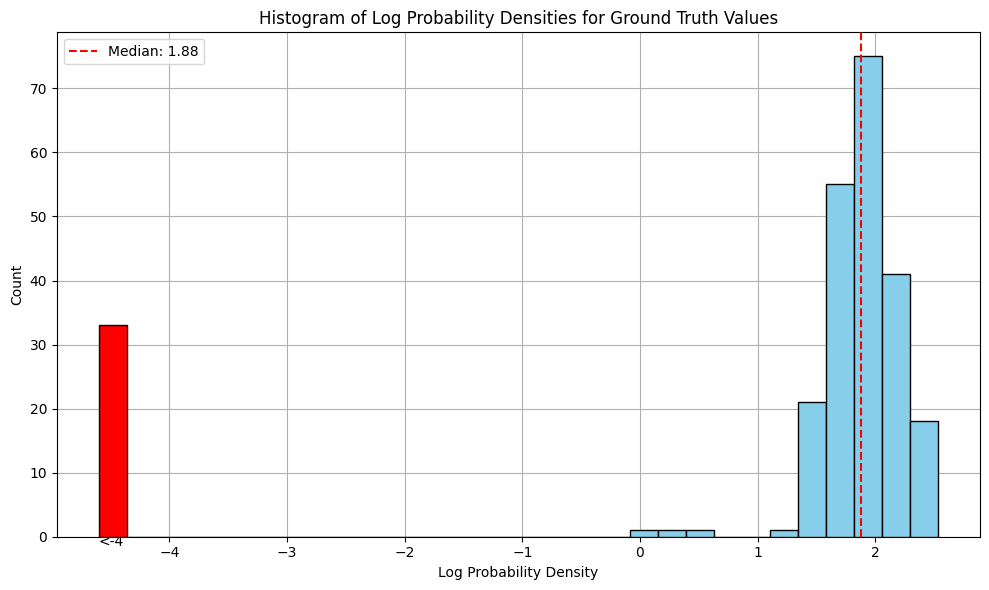

In [23]:
logp_for_plotting = logp_array.copy()
logp_for_plotting[logp_for_plotting<-4] = -4.6

# Remove -inf values for plotting
finite_logp = logp_for_plotting[np.isfinite(logp_for_plotting)]

# Plot histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(finite_logp, bins=30, color='skyblue', edgecolor='black', zorder=100)
plt.title("Histogram of Log Probability Densities for Ground Truth Values")
plt.xlabel("Log Probability Density")
plt.ylabel("Count")
plt.grid(True)
plt.axvline(np.median(finite_logp), color='red', linestyle='--', label=f"Median: {np.median(finite_logp):.2f}", zorder=101)

for i in np.where(bins<-1.1)[0]: 
    patches[i].set_facecolor('orange')
patches[0].set_facecolor('red')

plt.legend()

plt.text(-4.5, -1.4, '<-4', ha='center')

plt.tight_layout()


In [15]:
good = len(logp_array[logp_array>-1])
bad = len(logp_array[logp_array<-1])
total = len(logp_array.flatten())
print('Elasticities with good estimations:', good, f'({round(good*100/total,2)}%)')
print('Elasticities with bad estimations:', bad, f'({round(bad*100/total,2)}%)')

Elasticities with good estimations: 214 (86.64%)
Elasticities with bad estimations: 33 (13.36%)


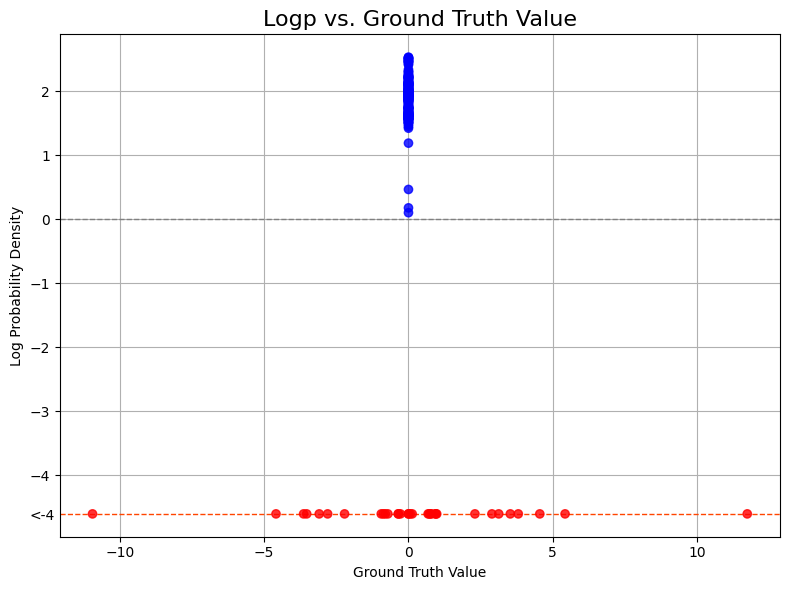

In [16]:
# Example arrays
true_values = r.getScaledElasticityMatrix().flatten()
logp_values = logp_array.flatten()

# Remove -inf or NaN
mask = np.isfinite(logp_values)
true_values = true_values# [mask]
logp_values = logp_for_plotting

conditions = [
    logp_values < -4,
    (logp_values >= -4) & (logp_values < -1),
    logp_values >= -1
]

choices = ['red', 'darkorange', 'blue']

colors = np.select(conditions, choices).flatten()

plt.figure(figsize=(8, 6))
plt.grid(True)
plt.scatter(true_values, logp_values, c=colors, alpha=0.8, zorder=100)
plt.xlabel("Ground Truth Value")
plt.ylabel("Log Probability Density")
plt.title("Logp vs. Ground Truth Value", fontsize=16)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.axhline(-4.6, color='orangered', linestyle='--', linewidth=1)
plt.text(-12.68, -4.7, '<-4', ha='center')

plt.tight_layout()


# For all traces

In [17]:
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']
traces = [trace01, trace02, trace03, trace04, trace05, trace15, trace3, trace5, trace7, trace100]

In [18]:
logp_arrays = [get_logp(i[0], true_values=r.getScaledElasticityMatrix()) for i in traces]

C:\Users\user\AppData\Local\Temp\ipykernel_3488\95413887.py:24: RuntimeWarning:

divide by zero encountered in log



In [19]:
np.max([i.max() for i in logp_arrays])

2.5337903790136265

C:\Users\user\AppData\Local\Temp\ipykernel_3488\2814568961.py:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\user\AppData\Local\Temp\ipykernel_3488\2814568961.py:36: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



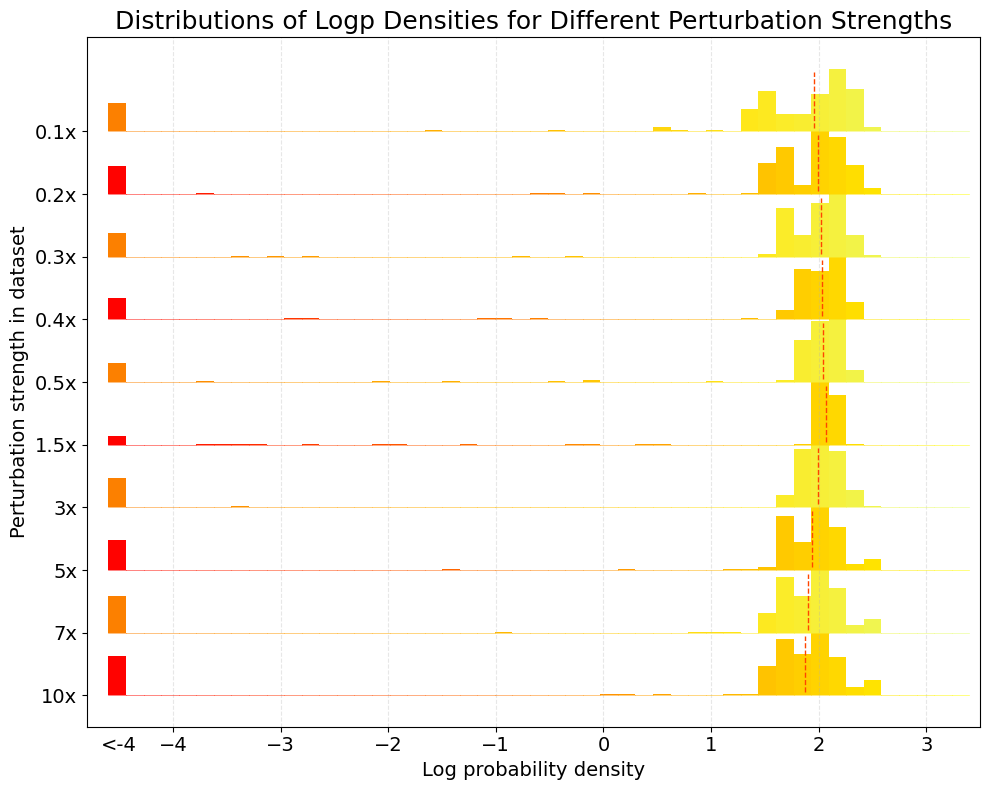

In [20]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

# Clip and flatten all traces
clipped_arrays = []
for i, logp_array in enumerate(logp_arrays):
    clipped = logp_array.copy()
    clipped[clipped < -4] = -4.6
    clipped = clipped[np.isfinite(clipped)].flatten()
    clipped_arrays.append(pd.Series(clipped, name=pt_labels[i]))

df = pd.concat(reversed(clipped_arrays), axis=1)

# Parameters
num_traces = df.shape[1]
bins = np.linspace(-4.6, 3.4, 50)
height = 1.0

# Setup color gradient left to right
cmap = get_cmap("RdGy")
norm = Normalize(vmin=bins[0], vmax=bins[-1])

# Plot
plt.figure(figsize=(10, 8))

for plot_idx in range(num_traces):
    
    col = df.columns[plot_idx]
    values = df[col].dropna()
    hist, bin_edges = np.histogram(values, bins=bins)
    hist = hist / hist.max()
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Alternate colormaps per row
    cmap_name = "Wistia_r" if (num_traces - 1 - plot_idx) % 2 == 0 else "autumn"
    cmap = get_cmap(cmap_name)
    norm = Normalize(vmin=bins[0], vmax=bins[-1])

    for i in range(len(hist)):
        color = cmap(norm(bin_centers[i]))
        plt.fill_between([bin_edges[i], bin_edges[i+1]],
                         plot_idx * height,
                         plot_idx * height + hist[i],
                         color=color, step='pre', linewidth=0)

        plt.plot([bin_edges[i], bin_edges[i+1]],
                 [plot_idx * height, plot_idx * height],
                 color=color, linewidth=0.5, alpha=0.7)

    # Median line
    median = np.median(values)
    plt.axvline(median,
                ymin=(plot_idx * height) / ((num_traces+1) * height) + 0.05,
                ymax=((plot_idx * height + 1) / ((num_traces+1) * height)) + 0.04,
                color='orangered',
                linestyle='--',
                linewidth=1)

# Formatting
plt.xticks(fontsize=14)
plt.yticks(height * np.arange(num_traces), [f"{pt_labels[i]}" for i in range(num_traces)][::-1], fontsize=14)
plt.xlabel("Log probability density", fontsize=14)
plt.ylabel("Perturbation strength in dataset", fontsize=14)
plt.title("Distributions of Logp Densities for Different Perturbation Strengths", fontsize=18)
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.xlim(-4.8,3.5)

plt.text(-4.5, -0.89, '<-4', ha='center', fontsize=14)

plt.tight_layout()


In [21]:
def calculate_goods(logp_array):
    good = len(logp_array[logp_array>-1])
    total = len(logp_array.flatten())
    return round(good*100/total,2)

for i in logp_arrays:
    print(calculate_goods(i))

89.47
89.47
89.07
89.07
89.47
89.88
87.45
87.04
87.04
86.64


In [25]:
where_nonzero = np.where(r.getScaledElasticityMatrix()!=0)
total = len(where_nonzero[0])
total

31

In [22]:
def calculate_nonzero_goods(logp_array):
    where_nonzero = np.where(r.getScaledElasticityMatrix()!=0)
    total = len(where_nonzero[0])
    good = 0
    for i in range(total):
        if logp_array[where_nonzero[0][i], where_nonzero[1][i]] > -1:
            good += 1

    return round(good*100/total,2)

for i in logp_arrays:
    print(calculate_nonzero_goods(i))

16.13
16.13
12.9
12.9
16.13
19.35
0.0
0.0
0.0
0.0


In [1]:
import numpy as np
np.mean([16.13,
16.13,
12.9,
12.9,
16.13,
19.35,
0.0,
0.0,
0.0,
0.0])

9.354000000000001